In [87]:
import sys
import importlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import re
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact, combine_pvalues
from scipy.stats import chi2_contingency
import pysam
from tqdm import tqdm
from scipy.optimize import curve_fit


plt.rcdefaults()
# mpl.rcParams[''] = 42
# mpl.rcParams['font.size'] = 14

plt.style.use('default')

def theme_classic():
    mpl.rcParams.update({
        'pdf.fonttype': 42,
        'font.size': 12,
        'axes.grid': False,
        'axes.facecolor': 'white',
        'figure.facecolor': 'white',
        'axes.edgecolor': 'black',
        'axes.linewidth': 1.0,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'xtick.direction': 'out',
        'ytick.direction': 'out'
    })

theme_classic()

## Quality Control

### number of reads

In [58]:
inpath = "../data/chrom/full_data/"
fs = os.listdir(inpath)
flagstat_files = sorted([f for f in fs if re.search(r'flagstat.txt$', f)])
print(flagstat_files)
samples = ['WT rep1', 'MUT rep1', 'WT rep2', 'MUT rep2']
samples_i  = [0, 2, 1, 3]
flagstat_files = [flagstat_files[i] for i in samples_i]
samples = [samples[i] for i in samples_i]

outf = open('../data/supp/Supp_number_of_reads.tsv', 'w')
outf.write('sample\tprimary_total\tprimary_mapped\n')
totals, mappeds = [], []
for i, f in enumerate(flagstat_files):
    
    with open(os.path.join(inpath, f)) as fh:
        content = fh.read()

    total = re.search(r"(\d+) \+ \d+ primary", content)
    mapped = re.search(r"(\d+) \+ \d+ primary mapped", content)
    
    n_total = int(total.group(1)) if total else 0
    n_mapped = int(mapped.group(1)) if mapped else 0
    totals.append(n_total)
    mappeds.append(n_mapped)
    outf.write(f'{samples[i]}\t{n_total}\t{n_mapped}\n')

outf.close()

['230824_ys18_150UNuc_Rep1_R10_movesOut.flagstat.txt', '230908_ym209_150UNUC_Rep1_R10_movesout.flagstat.txt', '230928_ys18_150UNuc_Rep2_R10_movesOut.flagstat.txt', '231006_ym209_150UNuc_Rep2_R10.flagstat.txt']


In [59]:
plt.figure(figsize=(5, 3))

plt.barh(samples, totals, height=0.5, color='#66c2a5', label='Total reads')
plt.barh(samples, mappeds, height=0.5, color='#fc8d62', label='Primary mapped reads')

plt.xlabel("Number of reads")
plt.legend()
plt.tight_layout()
plt.savefig('../figures/Supp_chromatin_total_number_of_reads.pdf')
plt.close()

### readlength

In [36]:
inpath = "../data/chrom/full_data/sub5k/"
fs = os.listdir(inpath)
bams = sorted([f for f in fs if re.search(r'.pass.sorted.bam$', f)])
samples = ['WT rep1', 'MUT rep1', 'WT rep2', 'MUT rep2']
samples_i  = [0, 2, 1, 3]
bams = [bams[i] for i in samples_i]
samples = [samples[i] for i in samples_i]
print(bams)
print(samples)

['230824_ys18_150UNuc_Rep1_R10_movesOut_sub5k.pass.sorted.bam', '230928_ys18_150UNuc_Rep2_R10_movesOut_sub5k.pass.sorted.bam', '230908_ym209_150UNUC_Rep1_R10_movesout_sub5k.pass.sorted.bam', '231006_ym209_150UNuc_Rep2_R10_sub5k.pass.sorted.bam']
['WT rep1', 'WT rep2', 'MUT rep1', 'MUT rep2']


In [42]:
def read_level_qc(bam, max_reads=None):
    aveReadLen, aveReadqual = [], []
    readCount = 0
    
    samfile = pysam.AlignmentFile(bam, "rb")
    for s in samfile:
        if s.is_mapped and not s.is_supplementary and not s.is_secondary:
            aveReadLen.append(np.log10(s.reference_length + 1))
            aveReadqual.append(np.mean(s.query_qualities))
            readCount += 1
        
        if max_reads and readCount >= max_reads:
            break

    samfile.close()
    return aveReadLen, aveReadqual

In [46]:
outf = open('../data/supp/Supp_readlength_qc.tsv', 'w')
outf.write('sample\treadlength_mean\treadlength_median\treadlength_std\t''readquality_mean\treadquality_median\treadquality_std\n')

allreadLens, allreadQuals = [], []
for bam in bams:
    
    readLens, readQuals = read_level_qc(inpath + bam)
    
    outf.write(
        f"{samples[i]}\t"
        f"{np.mean(readLens):.4f}\t{np.median(readLens):.4f}\t{np.std(readLens):.4f}\t"
        f"{np.mean(readQuals):.4f}\t{np.median(readQuals):.4f}\t{np.std(readQuals):.4f}\n"
    )

    allreadLens.append(readLens)
    allreadQuals.append(readQuals)

outf.close()

In [52]:
cmap = ['#5D3A9B', '#9467bd', '#d95f02', '#ff7f00']

plt.figure(figsize=(5, 3))
for i in tqdm(range(len(allreadLens))):
    plt.barh(i, np.median(allreadLens[i]), height=0.5, color=cmap[i])

plt.yticks(np.arange(0, len(allreadLens)), samples)
plt.xlabel('Median log10 read length')
plt.tight_layout()
plt.savefig('../figures/Supp_chromatin_median_readlengh.pdf', bbox_inches='tight')
plt.close()

plt.figure(figsize=(5, 3))
for i in tqdm(range(len(allreadQuals))):
    plt.barh(i, np.median(allreadQuals[i]), height=0.5, color=cmap[i])

plt.yticks(np.arange(0, len(allreadQuals)), samples)
plt.xlabel('Median read quality')
plt.tight_layout()
plt.savefig('../figures/Supp_chromatin_median_read_quality.pdf', bbox_inches='tight')
plt.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 204.66it/s]


## Make chromatin state count table from all samples

In [67]:
inpath = "../data/supp/"
outdir = '../data/'
prefix = '4_chromatin_state'

In [68]:
fs = os.listdir(inpath)
fs = sorted([f for f in fs if re.search(r'nuc_cluster_count.tsv$', f) and re.search(r'^251012', f)])

counts = []
for f in fs:
    full_path = os.path.join(inpath, f)
    df = pd.read_csv(full_path, sep="\t", index_col=0)
    counts.append(df)

count = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how="outer"), counts)
count.index.name = 'nucid'
count = count.fillna(0).astype(int)

count = count[count.sum(axis=1) >= 10]
count = count[np.sum(count != 0, axis=1) >= 2]

count['geneid'] = count.index.str.split(":").str[0]
gene_sum = count.groupby("geneid").sum()
valid_genes = gene_sum[(gene_sum != 0).all(axis=1)].index
count = count[count["geneid"].isin(valid_genes)]

count.drop(columns='geneid').to_csv(os.path.join(outdir, f"{prefix}_count.tsv"), sep='\t')

usage = count.groupby('geneid').transform(lambda x: x / x.sum())
usage.to_csv(os.path.join(outdir, f"{prefix}_usage.tsv"), sep='\t')

## find differentially enriched chromatin state with chi-square test

In [69]:
def fisher_test(counts, event, eps=1e-300, muts = ["MUT_rep1", "MUT_rep2"], wts = ["WT_rep1", "WT_rep2"]):
    
    # between condition
    pvals = []
    log2_ors = []
    for rep_mut in muts:
        for rep_wt in wts:
            mut_count = counts.loc[event, rep_mut].sum()
            wt_count = counts.loc[event, rep_wt].sum()
            mut_other = counts[rep_mut].sum() - mut_count
            wt_other = counts[rep_wt].sum() - wt_count
            
            table = np.array([[mut_count, mut_other],
                      [wt_count, wt_other]])
    
            table = table + 1
    
            # odd_ratio, p = fisher_exact(table)
            chi2, p, dof, expected = chi2_contingency(table)
            odds_ratio = (table[0, 0] * table[1, 1]) / (table[0, 1] * table[1, 0])
            
            p = max(p, eps)
            pvals.append(p)
            log2_ors.append(np.log2(odds_ratio))
    
    _, combined_p = combine_pvalues(pvals, method="fisher")
    n_sig = (np.array(pvals) < 0.05).sum()

    # within wt
    rep1_count = counts.loc[event, wts[0]]
    rep2_count = counts.loc[event, wts[1]]
    rep1_other = counts[wts[0]].sum() - rep1_count
    rep2_other = counts[wts[1]].sum() - rep2_count
    
    table_wt = np.array([[rep1_count, rep1_other],
                          [rep2_count, rep2_other]]) + 1

    odd_wt, p_wt = fisher_exact(table_wt)
    p_wt = max(p_wt, eps)

    # within mut
    rep1_count = counts.loc[event, muts[0]]
    rep2_count = counts.loc[event, muts[1]]
    rep1_other = counts[muts[0]].sum() - rep1_count
    rep2_other = counts[muts[1]].sum() - rep2_count
    
    table_mut = np.array([[rep1_count, rep1_other],
                          [rep2_count, rep2_other]]) + 1

    odd_mut, p_mut = fisher_exact(table_mut)
    p_mut = max(p_mut, eps)

    return np.mean(log2_ors), combined_p, n_sig, p_wt, p_mut


def bh_fdr(pval):
    """
    Benjamani-Hochberg FDR method from: 
    https://github.com/ctokheim/deepDegron/blob/663e17b558970e95ba04c986ae922f7954142d17/deepDegron/pvalue.py
    
    Parameters
    ----------
    pval : list or array
    
    Returns: 
    -------
    pval_adj : np.array
        adjusted p-values according the benjamani-hochberg method
    """
    
    pval_array = np.array(pval)
    sorted_order = np.argsort(pval_array)
    original_order = np.argsort(sorted_order)
    pval_array = pval_array[sorted_order]

    # calculate the needed alpha
    n = float(len(pval))
    pval_adj = np.zeros(int(n))
    i = np.arange(1, int(n)+1, dtype=float)[::-1]  # largest to smallest
    pval_adj = np.minimum(1, np.minimum.accumulate(n/i * pval_array[::-1]))[::-1]
    
    return pval_adj[original_order]



def diff_nuc(count):
    
    res = []
    for gene, group in count.groupby("geneid"):
        for event in group.index:
            log2_or, pval, n, p_wt, p_mut = fisher_test(group, event)
            res.append({"nucid": event, "geneid": gene, "log2_or": log2_or, "pval": pval, "n_sig": n, "pval_wt": p_wt, "pval_mut": p_mut})
        
    res_df = pd.DataFrame(res)
    res_df['pval_adj'] = bh_fdr(res_df['pval'])
    res_df['pval_adj_wt']  = bh_fdr(res_df['pval_wt'])
    res_df['pval_adj_mut']  = bh_fdr(res_df['pval_mut'])
    res_df = res_df.set_index('nucid')

    return res_df

res_df = diff_nuc(count)

usage["mean_MUT"] = usage[["MUT_rep1", "MUT_rep2"]].mean(axis=1)
usage["mean_WT"]  = usage[["WT_rep1", "WT_rep2"]].mean(axis=1)
usage["delta"] = usage["mean_MUT"] - usage["mean_WT"]

res_df = res_df.join(usage[["mean_MUT", "mean_WT", "delta"]])

res_df.to_csv(os.path.join(outdir, f"{prefix}_diff_nuc.tsv"), sep='\t')

## plot aggregated nucleosome occupancy plot

### WT samples between gene expression

In [85]:
def sin_model(x, A, phi, C):
    P = 180  # fixed nucleosome period
    return A * np.sin(2*np.pi*x/P + phi) + C

In [72]:
inpath = '../data/chrom/'

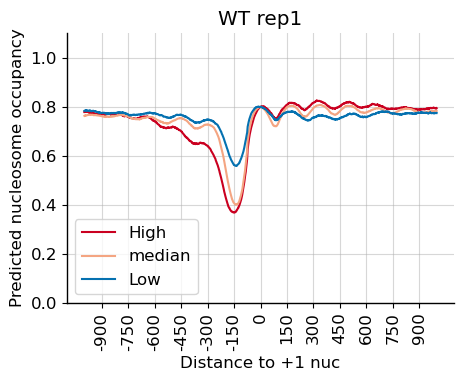

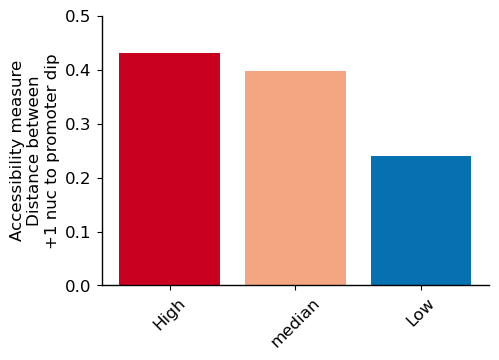

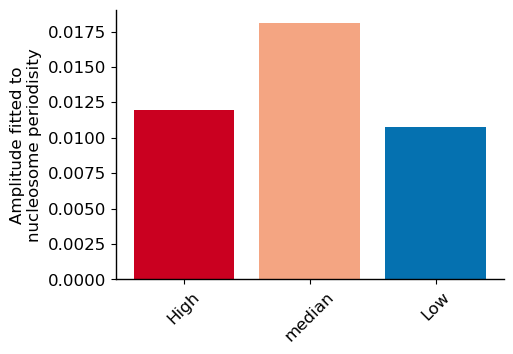

In [90]:
# WT rep1
fig, ax1 = plt.subplots(figsize=(5, 3.5))
ys18_rep1_agg_high = f'{inpath}251111_high_expr_genes_denovo_plus_one_ys18_rep1_aggregate_score.tsv'
ys18_rep1_agg_middle = f'{inpath}251111_middle_expr_genes_denovo_plus_one_ys18_rep1_aggregate_score.tsv'
ys18_rep1_agg_low = f'{inpath}251111_low_expr_genes_denovo_plus_one_ys18_rep1_aggregate_score.tsv'

allagg = [ys18_rep1_agg_high, ys18_rep1_agg_middle, ys18_rep1_agg_low]

hw = int(2000/2)
space=150
labels = ['High', 'median', 'Low']
cmap = ["#ca0020", "#f4a582",  "#0571b0"]

dists = []
amplitudes = []
k = 1
for i in range(len(allagg)):
    with open(allagg[i], 'r') as infile:
        agg_scores = []
        for line in infile:
            line = line.strip().split('\t')
            agg_scores.append(float(line[k]))
        
        # dist between peak to dip
        peak = max(agg_scores[995:1005])
        dip = min(agg_scores[845:855])
        dist = 0.8 - peak
        agg_scores_norm = [s + dist for s in agg_scores]
        dists.append(peak-dip)

        x = np.arange(-hw, hw+1)
        y = np.array(agg_scores_norm)
        
        # magnitute
        mask = (x > 0) & (x < 800)
        x_fit = x[mask]
        y_fit = y[mask]
        
        popt, _ = curve_fit(sin_model,x_fit,y_fit, p0=[0.1, 0, 0.5])
        
        A_fit = abs(popt[0])
        amplitudes.append(A_fit)

        ax1.plot(np.arange(-hw, hw+1), agg_scores_norm, label = labels[i], color=cmap[i], alpha=1)

x_ticks = np.concatenate((np.flip(np.arange(0, -hw-1, -space)[1:]), np.arange(0, hw+1, space)), axis=0)
ax1.grid(alpha=0.5)
ax1.set_xticks(x_ticks)

ax1.set_xticklabels(x_ticks, rotation='vertical')
ax1.set_xlabel("Distance to +1 nuc")
ax1.set_ylabel('Predicted nucleosome occupancy')
ax1.set_title('WT rep1')
ax1.set_ylim(0.0,1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend()
plt.savefig('../figures/Supp_agg_ys18_rep1_by_expr.pdf', bbox_inches='tight')
plt.show()
plt.close()


plt.figure(figsize=(5, 3.5))
left = 1
for i in range(len(dists)):
    plt.bar(left, dists[i], label = labels[i], color=cmap[i])
    left += 1

plt.ylim(0.0,0.5)

plt.xticks(np.arange(1, len(dists)+1), labels, rotation = 45)
plt.ylabel('Accessibility measure\nDistance between\n+1 nuc to promoter dip')
plt.savefig('../figures/Supp_distance_between_peak_dip_ys18_rep1_by_expr.pdf', bbox_inches='tight')

plt.figure(figsize=(5, 3.5))
left = 1
for i in range(len(dists)):
    plt.bar(left, amplitudes[i], label = labels[i], color=cmap[i])
    left += 1

plt.xticks(np.arange(1, len(dists)+1), labels, rotation = 45)
plt.ylabel('Amplitude fitted to\nnucleosome periodisity')
plt.savefig('../figures/Supp_amplitude_ys18_rep1_by_expr.pdf', bbox_inches='tight')
plt.show()
plt.close()

### all genes between genotypes

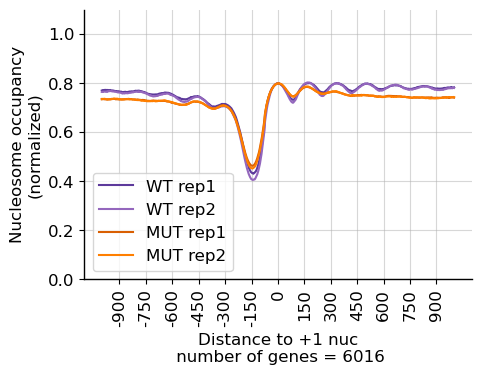

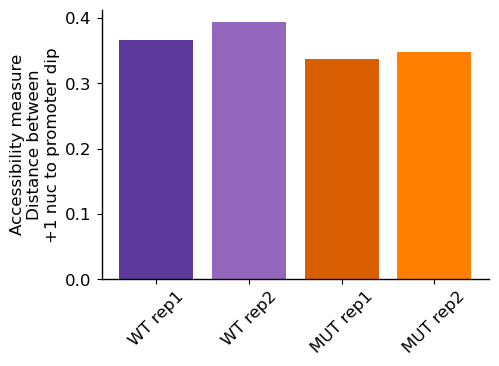

In [82]:
fig, ax1 = plt.subplots(figsize=(5, 3.5))
cmap = ['#5D3A9B', '#9467bd', '#d95f02', '#ff7f00']
ys18_rep1_agg = f'{inpath}251111_all_genes_denovo_plus_one_ys18_rep1_aggregate_score.tsv'
ys18_rep2_agg = f'{inpath}251111_all_genes_denovo_plus_one_ys18_rep2_aggregate_score.tsv'
ym209_rep1_agg = f'{inpath}251111_all_genes_denovo_plus_one_ym209_rep1_aggregate_score.tsv'
ym209_rep2_agg = f'{inpath}251111_all_genes_denovo_plus_one_ym209_rep2_aggregate_score.tsv'
allagg = [ys18_rep1_agg, ys18_rep2_agg, ym209_rep1_agg, ym209_rep2_agg]

hw = int(2000/2)
space=150
labels = ['WT rep1', 'WT rep2', 'MUT rep1', 'MUT rep2']
dists = []
amplitudes = []
k = 1
for i in range(len(allagg)):
    with open(allagg[i], 'r') as infile:
        agg_scores = []
        for line in infile:
            line = line.strip().split('\t')
            agg_scores.append(float(line[k]))
        
        # dist between peak to dip
        peak = max(agg_scores[995:1005])
        dip = min(agg_scores[845:855])
        dist = 0.8 - peak
        agg_scores_norm = [s + dist for s in agg_scores]
        dists.append(peak-dip)

        x = np.arange(-hw, hw+1)
        y = np.array(agg_scores_norm)
        
        # magnitute
        mask = (x > 0) & (x < 800)
        x_fit = x[mask]
        y_fit = y[mask]
        
        popt, _ = curve_fit(sin_model,x_fit,y_fit, p0=[0.1, 0, 0.5])
        
        A_fit = abs(popt[0])
        amplitudes.append(A_fit)

        ax1.plot(np.arange(-hw, hw+1), agg_scores_norm, label = labels[i], color=cmap[i], alpha=1)

x_ticks = np.concatenate((np.flip(np.arange(0, -hw-1, -space)[1:]), np.arange(0, hw+1, space)), axis=0)

ax1.grid(alpha=0.5)

ax1.set_xticks(x_ticks)

ax1.set_xticklabels(x_ticks, rotation='vertical')

ax1.set_xlabel(f"Distance to +1 nuc\n number of genes = {6016}")
ax1.set_ylabel('Nucleosome occupancy\n(normalized)')
ax1.set_ylim(0.0,1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend()
plt.savefig('../figures/Supp_agg_all_sample_all_genes_normalized.pdf', bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(5, 3.5))
left = 1
for i in range(len(dists)):
    plt.bar(left, dists[i], label = labels[i], color=cmap[i])
    left += 1
plt.xticks(np.arange(1, len(dists)+1), labels, rotation = 45)
plt.ylabel('Accessibility measure\nDistance between\n+1 nuc to promoter dip')
plt.savefig('../figures/Supp_distance_between_peak_dip_all_sample_all_genes.pdf', bbox_inches='tight')